# **Predict book sales**

# Table of Contents:
* Part 0: Introduction
* Part 1: Import, Load Data
* Part 2: Exploratory Data Analysis
* Part 3: Aggregating Time Series
* Part 4: Modeling
* Part 6: Disaggregating Total Sales Forecast

# Part 0: Introduction

## Overview
This dataset contanins data about books sales. It has 6 columns: **'row_id', 'date', 'country', 'store', 'product', 'num_sold'**

### Metadata:
* row_id - sale ID
* date - sale date
* country - country where book was sold
* store - store where book was sold
* product - name of the book
* num_sold - number of books sold  

## Questions:
* Predict book sales in 2021 year

# Part 1: Import, Load Data

In [1]:
# import standard libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# import model
from sklearn.linear_model import Ridge

In [2]:
# read data from '.csv' files
train = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2022/train.csv', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2022/test.csv', parse_dates=['date'])
original_train = train.copy()
original_test = train.copy()

# Part 2: Exploratory Data Analysis

### Info

In [3]:
display(train.info())
print()
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    70128 non-null  int64         
 1   date      70128 non-null  datetime64[ns]
 2   country   70128 non-null  object        
 3   store     70128 non-null  object        
 4   product   70128 non-null  object        
 5   num_sold  70128 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 3.2+ MB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   row_id   17520 non-null  int64         
 1   date     17520 non-null  datetime64[ns]
 2   country  17520 non-null  object        
 3   store    17520 non-null  object        
 4   product  17520 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 684.5+ KB


None

### Head

In [4]:
display(train.head())
display(test.head())

row_id       date  country       store                           product  \
0       0 2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1       1 2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2       2 2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3       3 2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4       4 2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   num_sold  
0       663  
1       615  
2       480  
3       710  
4       240

row_id       date  country       store                           product
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques

### Observations:
* There are 3 categorical columns that together describe a univariate time series. Country, Store and Product.
* There no null values

## Visualisation

In [5]:
def val_count_df(df, column_name, sort_by_column_name=False):
    value_count = df[column_name].value_counts().reset_index().rename(columns={column_name:'Value Count','index':column_name}).set_index(column_name)
    value_count['Percentage'] = df[column_name].value_counts(normalize=True)*100
    value_count = value_count.reset_index()
    if sort_by_column_name:
        value_count = value_count.sort_values(column_name)
    return value_count



def plot_and_display_valuecounts(df, column_name, sort_by_column_name=False):
    val_count = val_count_df(df, column_name, sort_by_column_name)
    #display(val_count)
    val_count.set_index(column_name).plot.pie(y='Value Count', figsize=(5,5), legend=False, ylabel='');

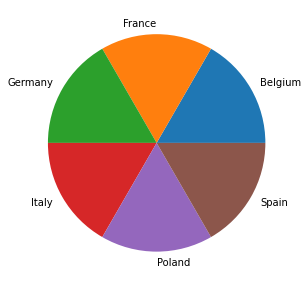

In [6]:
plot_and_display_valuecounts(train, 'country')

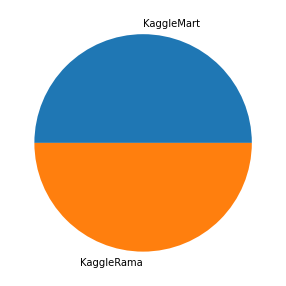

In [7]:
plot_and_display_valuecounts(train, "store")

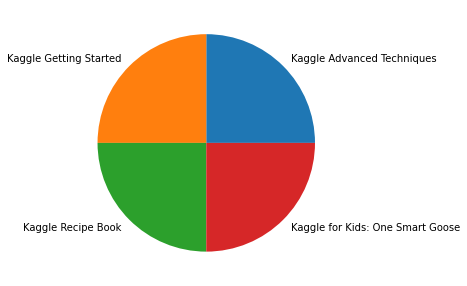

In [8]:
plot_and_display_valuecounts(train, "product")

### Observations:
* Every group seems to occur in equal amounts.


In [9]:
train.groupby(["country","store","product"])["num_sold"].count()

country  store       product                         
Belgium  KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
France   KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                

### Oservations:
*  Every country contains every store and every store contains every product.
*  Each for 1461

In [10]:
print("Train - Earliest date:", train["date"].min())
print("Train - Latest date:", train["date"].max())

print("Test - Earliest date:", test["date"].min())
print("Test - Latest date:", test["date"].max())

Train - Earliest date: 2017-01-01 00:00:00
Train - Latest date: 2020-12-31 00:00:00
Test - Earliest date: 2021-01-01 00:00:00
Test - Latest date: 2021-12-31 00:00:00


### Observations:
* We have **4 years** of data from 2017-01-01 to 2020-12-31 to train occuring at daily frequency.
* We are required to forecast 1 year of data, from 2021-01-01 to 2021-12-31.

In [11]:
weekly_df = train.groupby(["country","store", "product", pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

In [12]:
def plot_all(df):
    f,axes = plt.subplots(2,2,figsize=(20,15), sharex = True, sharey=True)
    f.tight_layout()
    for n,prod in enumerate(df["product"].unique()):
        plot_df = df.loc[df["product"] == prod]
        sns.lineplot(data=plot_df, x="date", y="num_sold", hue="country", style="store",ax=axes[n//2,n%2])
        axes[n//2,n%2].set_title("Product: "+str(prod))

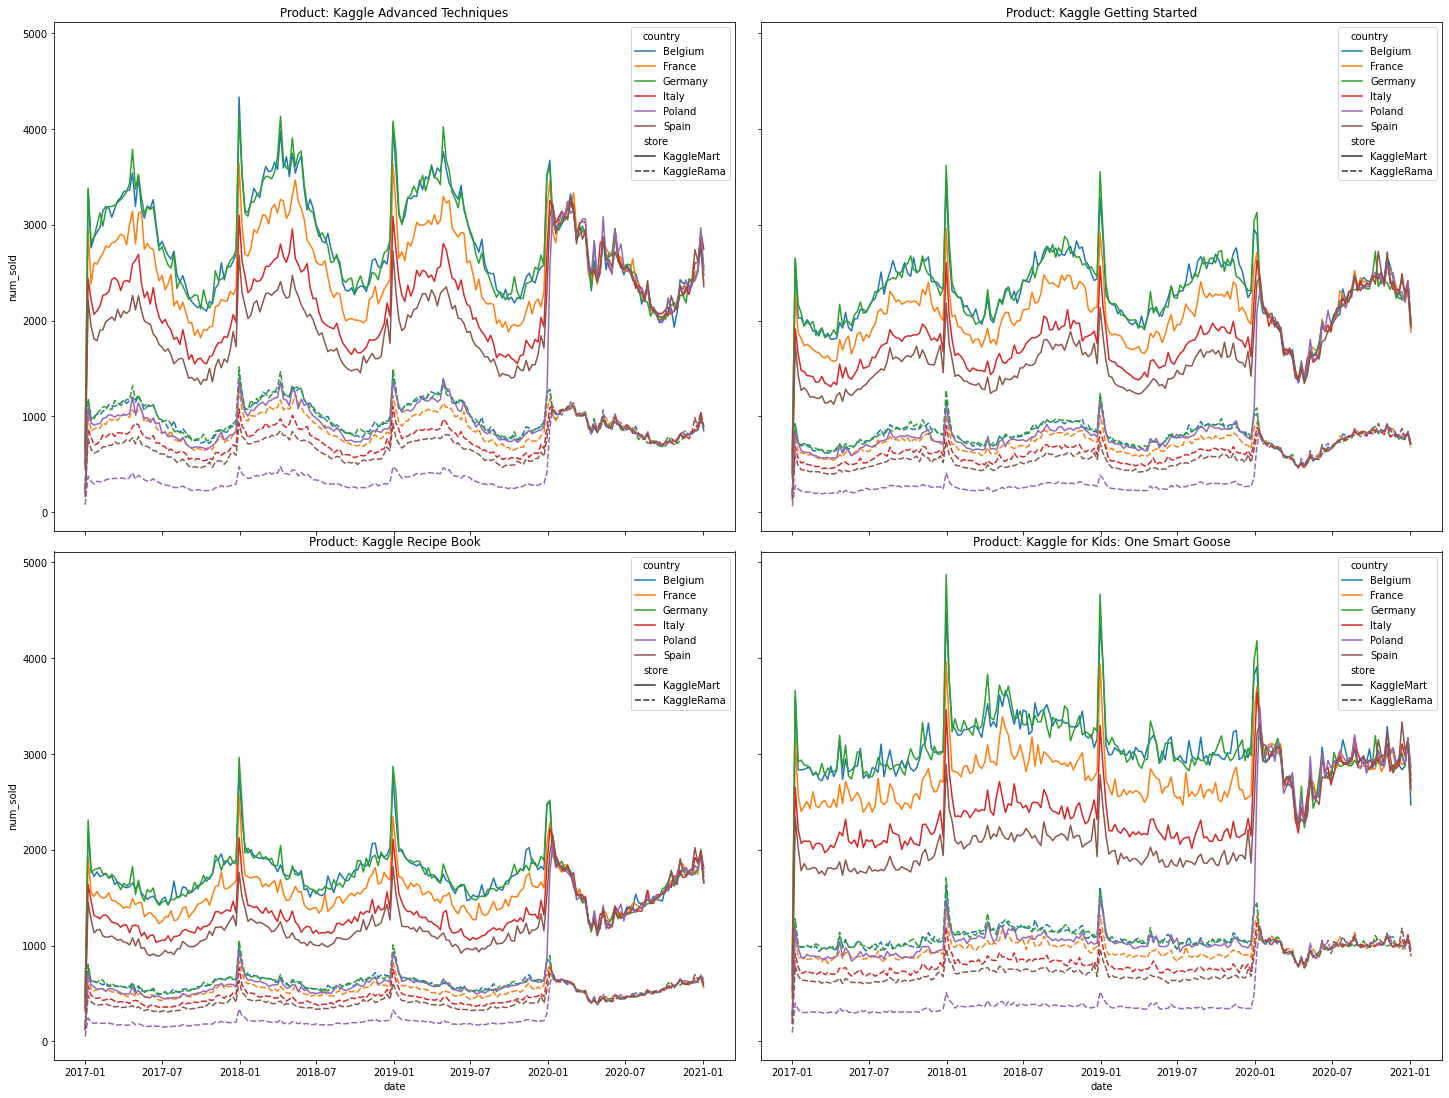

In [13]:
plot_all(weekly_df)

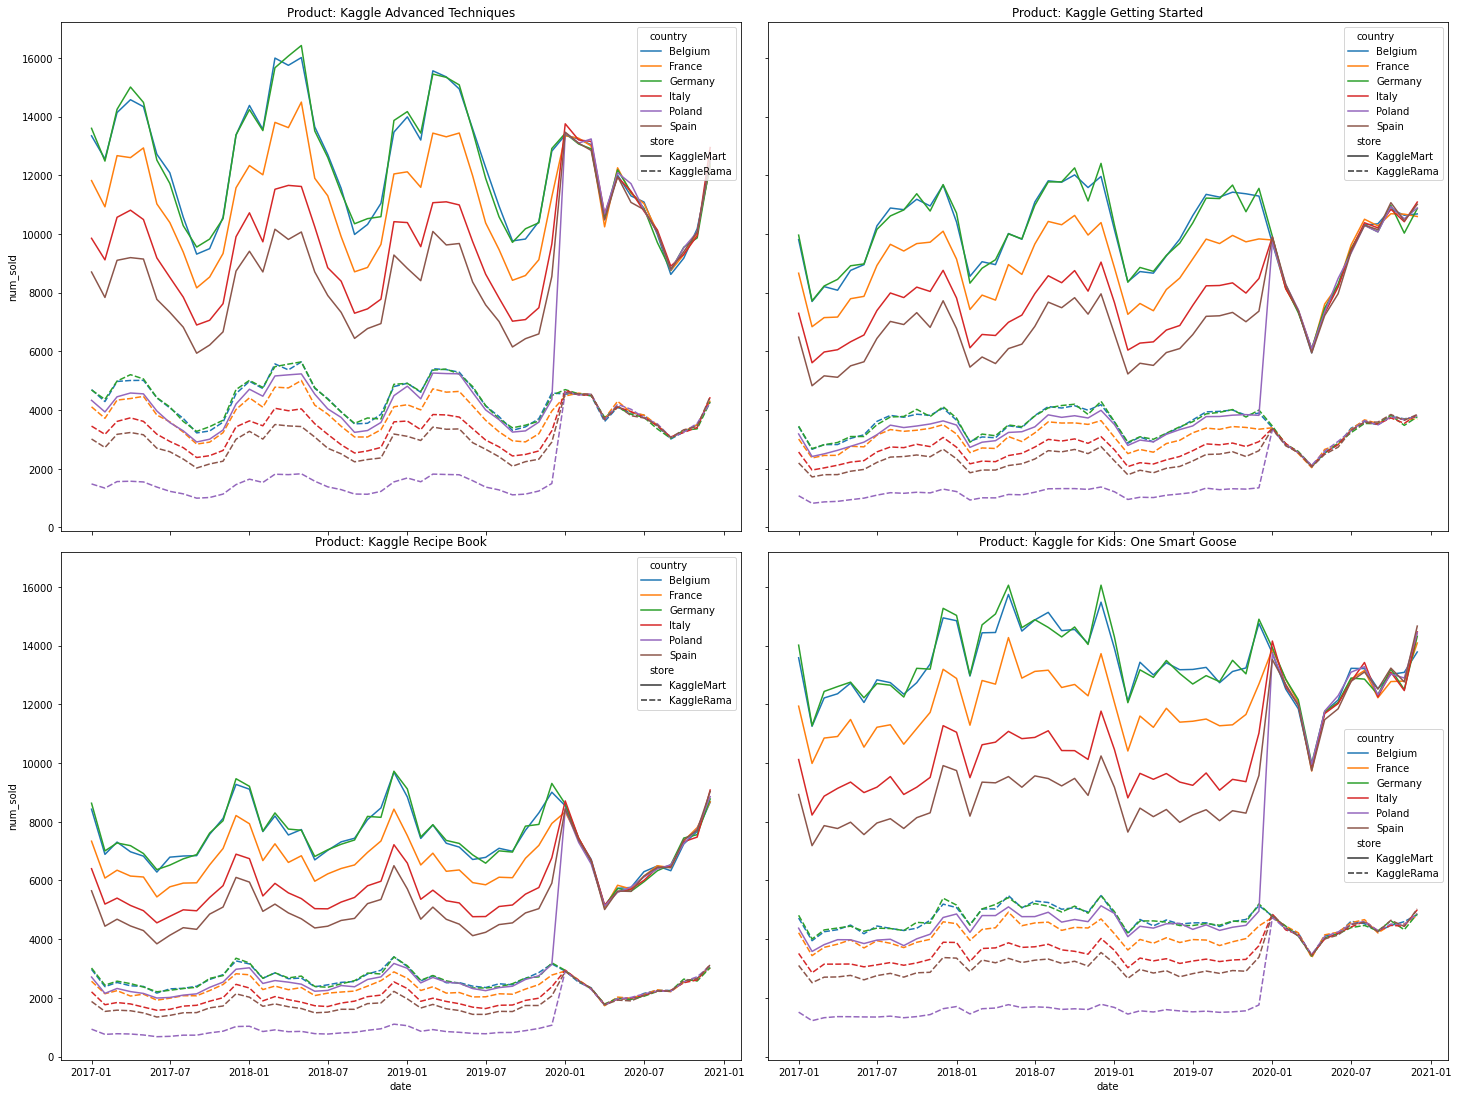

In [14]:
plot_all(monthly_df)

### Observations:

* The year 2020 is significantly different to other years, with sales being almost identical between countries.
* Each product has a different pattern in number of sales.
* It looks a lot like the pattern in sales between stores is identical. With KaggleMart and KaggleRama following the same pattern but with KaggleRama having less sales.
* Similarly it looks like the pattern in sales between all countries is identical, just with the magnitude of sales being different.

# Part 3: Data Wrangling and Transformation

### Store

In [15]:
store_weights = train.groupby("store")["num_sold"].sum()/train["num_sold"].sum()
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64

In [16]:
product_store_weights = monthly_df.groupby(["product","store"])["num_sold"].sum() / monthly_df.groupby(["product"])["num_sold"].sum()
product_store_weights

product                           store     
Kaggle Advanced Techniques        KaggleMart    0.742447
                                  KaggleRama    0.257553
Kaggle Getting Started            KaggleMart    0.742500
                                  KaggleRama    0.257500
Kaggle Recipe Book                KaggleMart    0.742765
                                  KaggleRama    0.257235
Kaggle for Kids: One Smart Goose  KaggleMart    0.742450
                                  KaggleRama    0.257550
Name: num_sold, dtype: float64

### Observation:
* KaggleMart appears to consistantly have ~74.25% of the total number of sales.

Let's equalize the sales values of stores.

In [17]:
def plot_adjusted_store(df):
    new_df = df.copy()
    weights = (product_store_weights.reset_index().groupby("store")["num_sold"].mean().loc["KaggleMart"] / product_store_weights.reset_index().groupby("store")["num_sold"].mean())
    for store in weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * weights[store]
    plot_all(new_df)

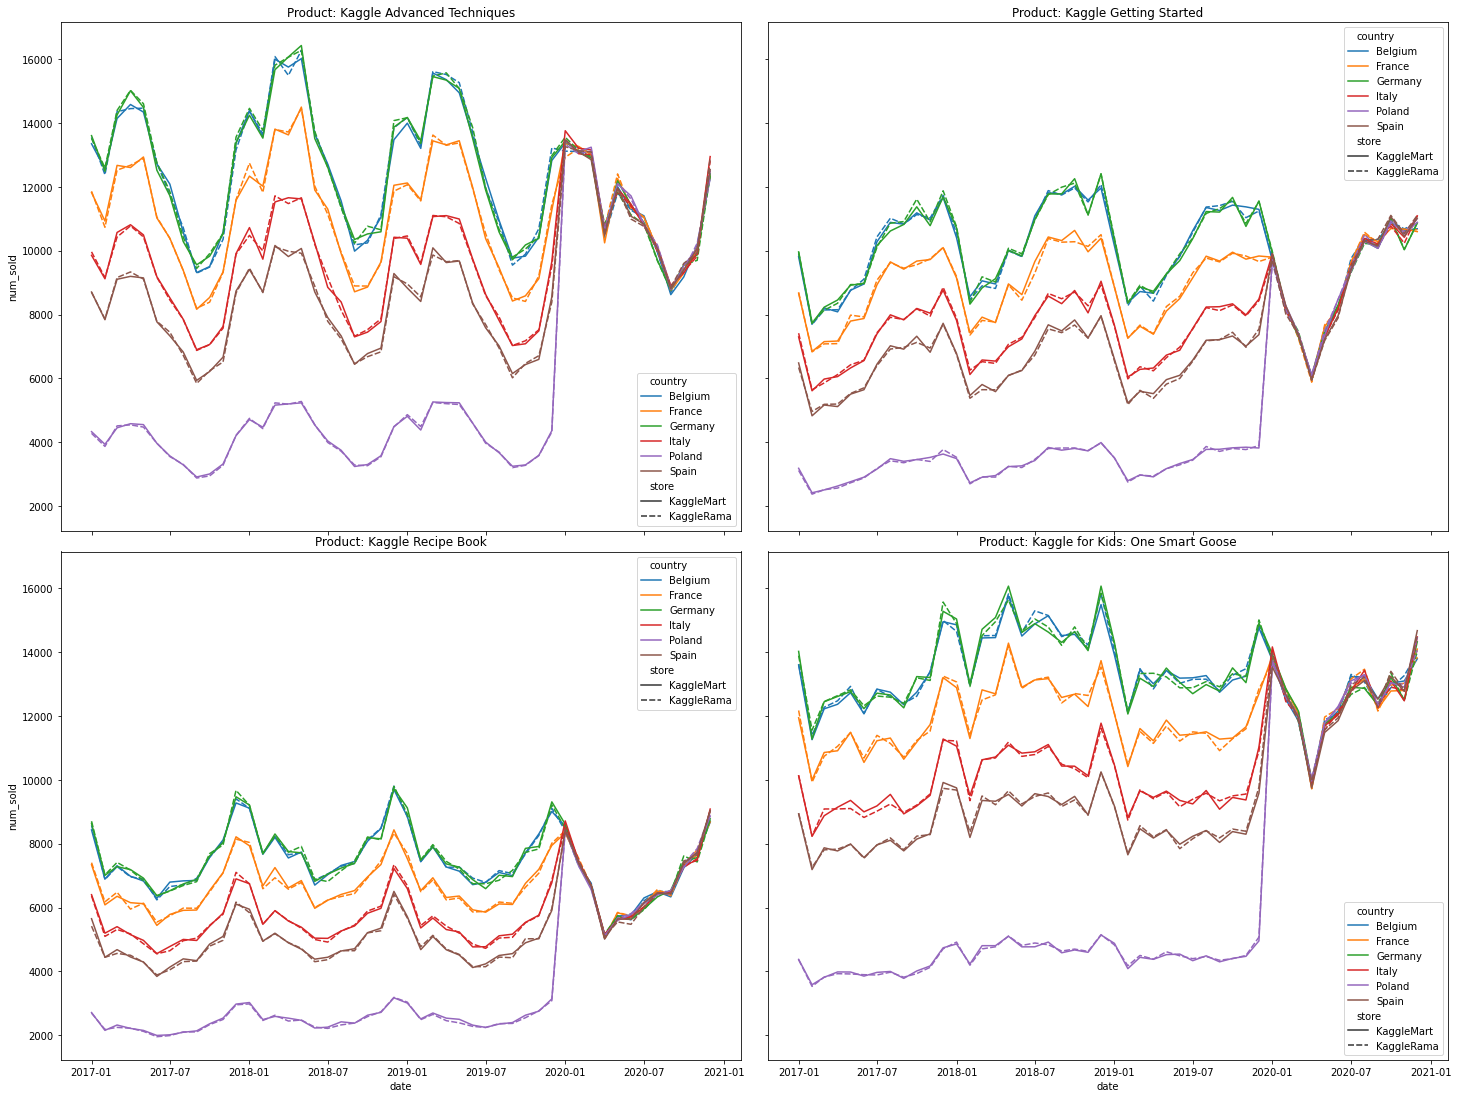

In [18]:
plot_adjusted_store(monthly_df)

### Observations:
* Trend and seasonality are not unique to the store and we can ignore its effect. All differences in sales can be explained by a single constant regardless of time.
* This means we can forecast the store aggregated timeseries, and then disaggregating the forecasts based on historical proportions.

### Countries:

In [19]:
new_monthly_df = monthly_df.loc[monthly_df["date"] < "2020-01-01"]
product_country_weights = new_monthly_df.groupby(["product","country"])["num_sold"].sum() / new_monthly_df.groupby(["product"])["num_sold"].sum()
product_country_weights

product                           country
Kaggle Advanced Techniques        Belgium    0.218832
                                  France     0.191456
                                  Germany    0.219423
                                  Italy      0.159464
                                  Poland     0.071352
                                  Spain      0.139474
Kaggle Getting Started            Belgium    0.219094
                                  France     0.191188
                                  Germany    0.219410
                                  Italy      0.159473
                                  Poland     0.071316
                                  Spain      0.139518
Kaggle Recipe Book                Belgium    0.219069
                                  France     0.191101
                                  Germany    0.219778
                                  Italy      0.159175
                                  Poland     0.071355
                                  Spain 

In [20]:
(product_country_weights.reset_index().groupby("country")["num_sold"].mean().loc["Belgium"] 
 / product_country_weights.reset_index().groupby("country")["num_sold"].mean())

country
Belgium    1.000000
France     1.144428
Germany    0.997088
Italy      1.373899
Poland     3.068876
Spain      1.570512
Name: num_sold, dtype: float64

### Observations:
* It doesn't seem too bad, although Poland seems a little off.

In [21]:
def plot_adjust_country(df):
    new_df = df.copy()
    
    weights = product_country_weights.reset_index().groupby("country")["num_sold"].mean().loc["Belgium"] / product_country_weights.reset_index().groupby("country")["num_sold"].mean()
    
    for country in weights.index:
        new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] = new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] *  weights[country]
    #plot_country_product(new_df)
    plot_all(new_df)

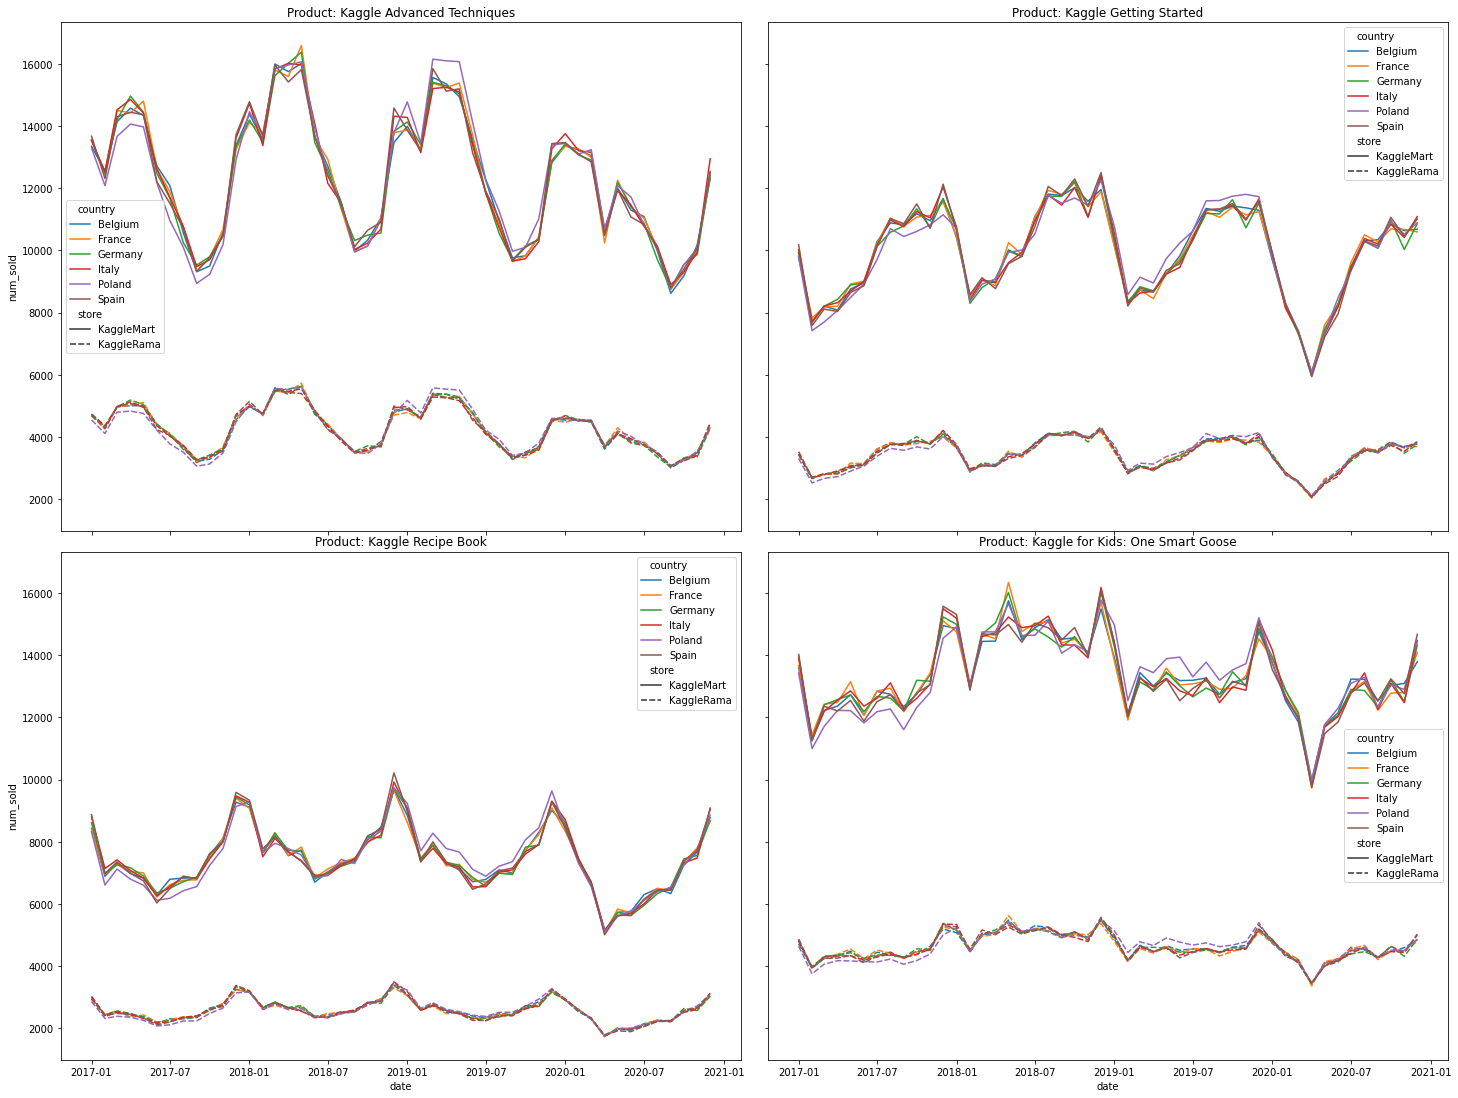

In [22]:
plot_adjust_country(monthly_df)

### Observations:
* We can forecast the country aggregated series, and then disaggregating the forecasts based on historical proportions.

## Country and Store

Lets try doing this to both country and store at the same time.

In [23]:
def plot_adjust_country_store(df):
    new_df = df.copy()
    
    store_weights = product_store_weights.reset_index().groupby("store")["num_sold"].mean().loc["KaggleMart"] / product_store_weights.reset_index().groupby("store")["num_sold"].mean()
    country_weights = product_country_weights.reset_index().groupby("country")["num_sold"].mean().loc["Belgium"] / product_country_weights.reset_index().groupby("country")["num_sold"].mean()
    
    for country in country_weights.index:
        new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] = new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] *  country_weights[country]
    for store in store_weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * store_weights[store]
    plot_all(new_df)

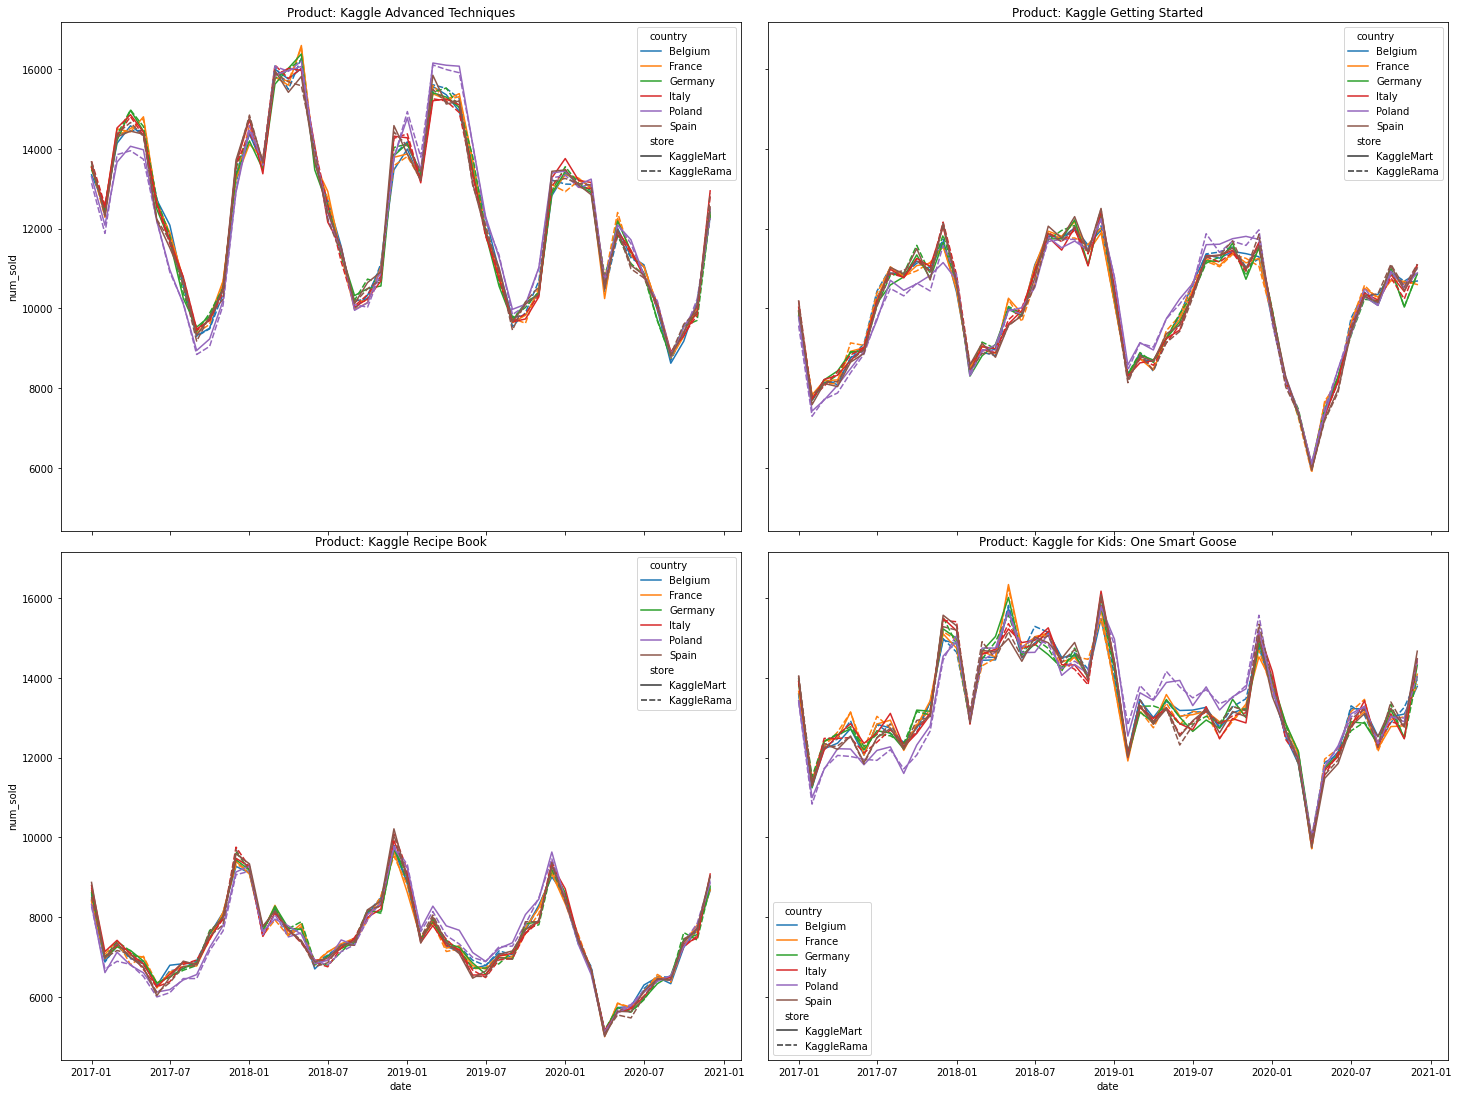

In [24]:
plot_adjust_country_store(monthly_df)

### Observations:
* Looks nice, except Poland

## Product

In [25]:
product_df = train.groupby(["date","product"])["num_sold"].sum().reset_index()
product_df.head()

date                           product  num_sold
0 2017-01-01        Kaggle Advanced Techniques      4267
1 2017-01-01            Kaggle Getting Started      3492
2 2017-01-01                Kaggle Recipe Book      2900
3 2017-01-01  Kaggle for Kids: One Smart Goose      4693
4 2017-01-02        Kaggle Advanced Techniques      3242

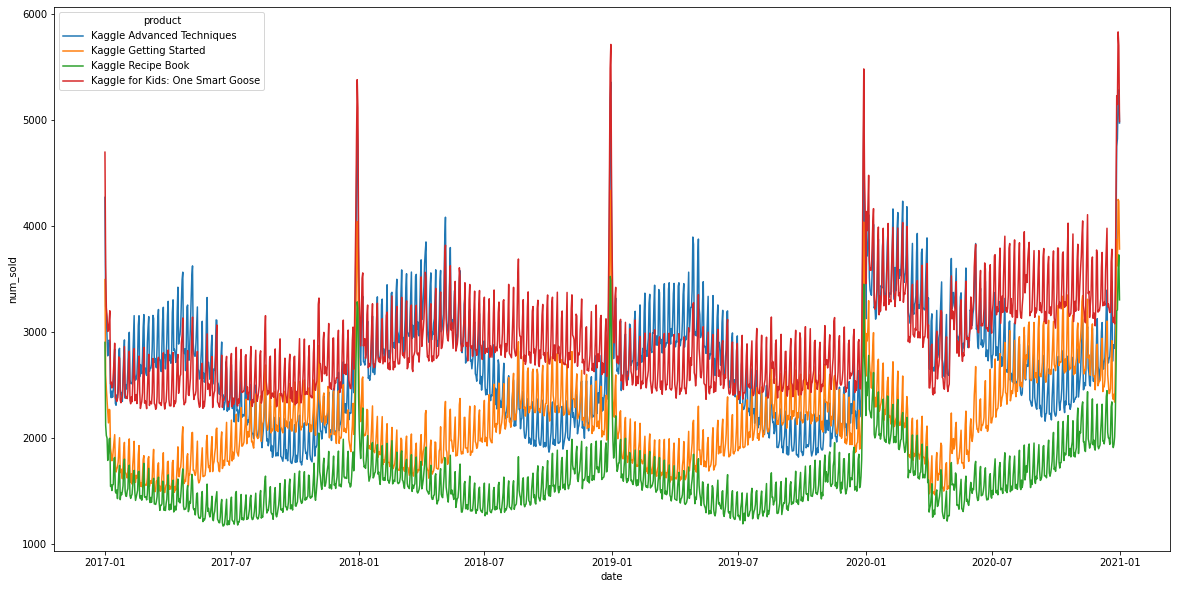

In [26]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=product_df, x="date", y="num_sold", hue="product");

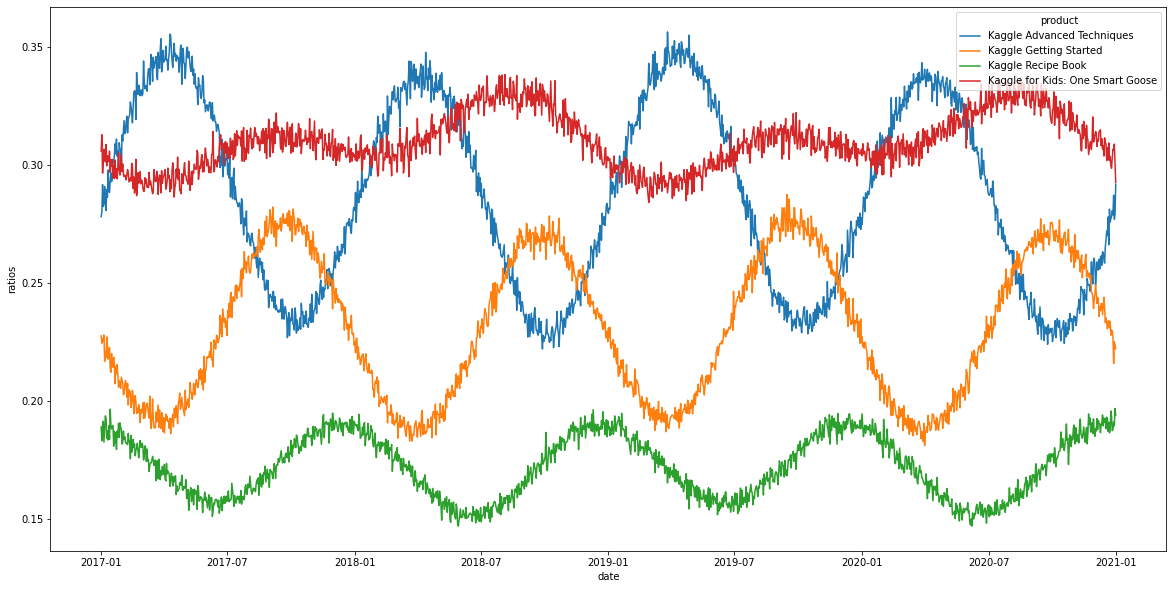

In [27]:
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = product_ratio_df, x="date", y="ratios", hue="product");

Observations:
* The product ratio shows clear sinsidual lines for each product
* As we have a clear seasonal pattern of the ratio of sales for each product, we do not need to forecast each product individually (or treat product as a categorical variable etc.). 
* Instead we can forecast the sum of all sales each day, then afterwards convert the forecasted sum down to the forecast for each product, using the forecasted ratios for each date.

# Part 4: Aggregated Time Series

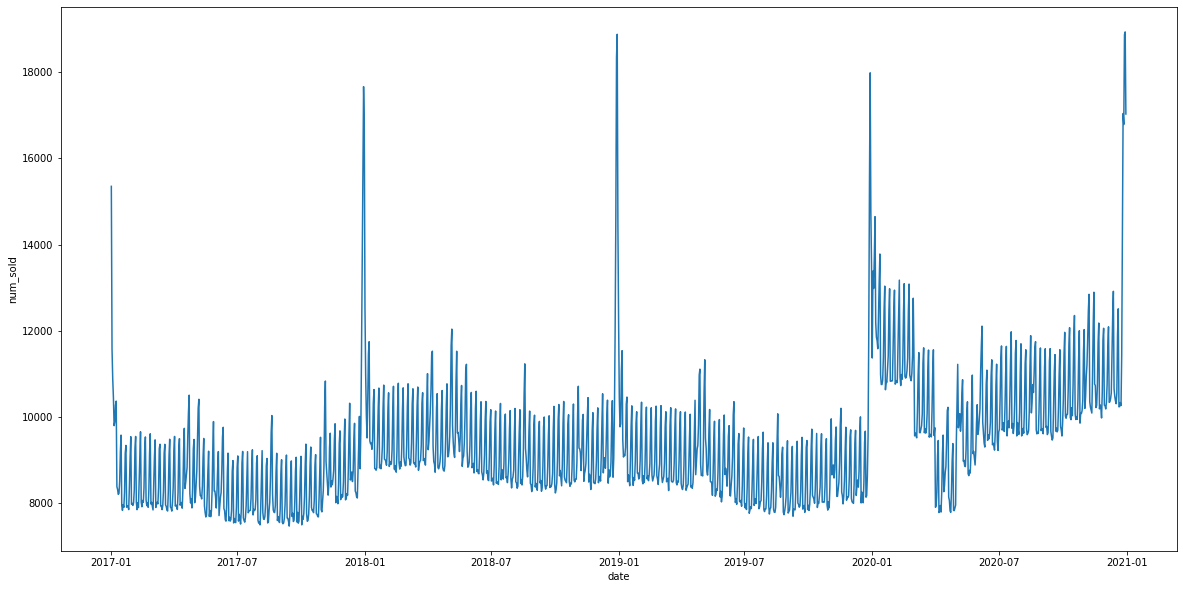

In [28]:
train = train.groupby(["date"])["num_sold"].sum().reset_index()
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train, x="date", y="num_sold");

## Seasonality

In [29]:
def plot_seasonality(df, x_axis):
    
    #remove the leap year date
    df = df.loc[df["date"] != "2020-02-29"].copy()

    df["month"] = df["date"].dt.month
    df["day_of_week"] = df["date"].dt.dayofweek
    df["day_of_year"] = df["date"].dt.dayofyear
    #account for leap year
    df["day_of_year"] = df.apply(lambda x: x["day_of_year"]-1 if x["date"] > pd.Timestamp("2020-02-29") else x["day_of_year"], axis=1)
        
    df_no_2020 = df.loc[df["date"] < "2020-01-01"]

    f,axes = plt.subplots(2,1,figsize=(20,16))
    sns.lineplot(data=df, x=x_axis, y="num_sold", ax=axes[0]);
    sns.lineplot(data=df_no_2020, x=x_axis, y="num_sold", ax=axes[1]);
    axes[0].set_title("{} Seasonality - all years".format(x_axis))
    axes[1].set_title("{} Seasonality - not including 2020".format(x_axis))

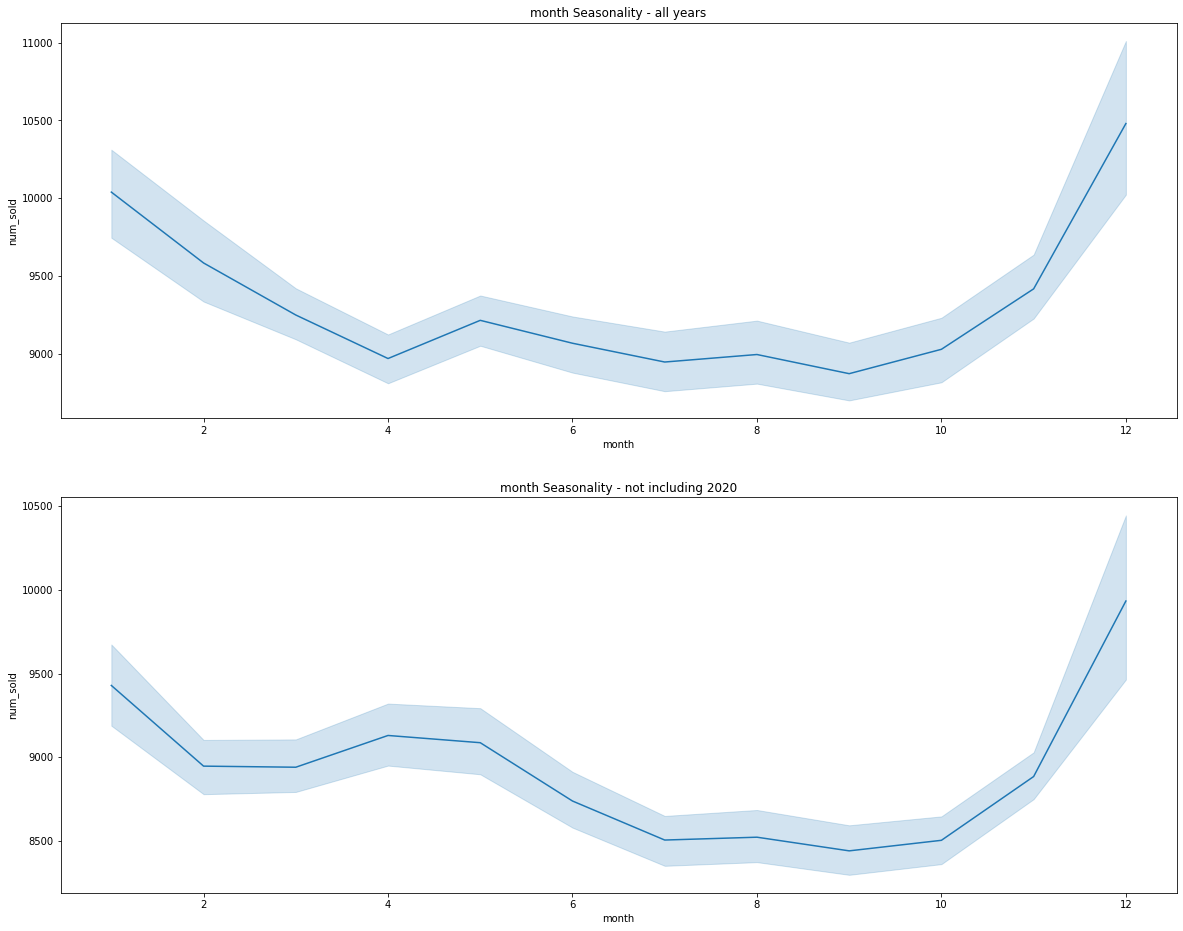

In [30]:
plot_seasonality(train, "month")

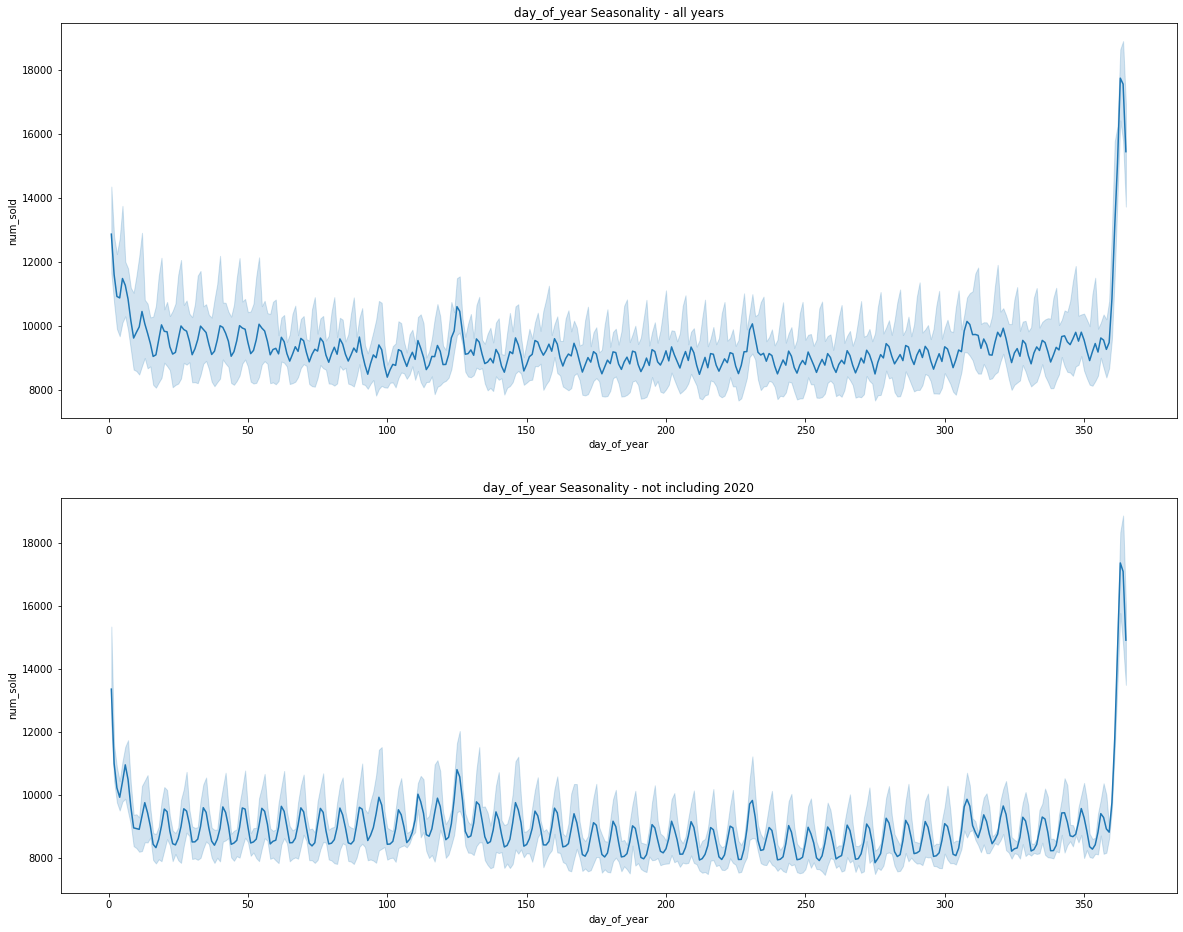

In [31]:
plot_seasonality(train, "day_of_year")

# Part 5: Modeling

We required 2 forecasts:

1. **Total Sales** Forecast
2. **Product Sales Ratio** Forecast

## Total Sales Forecast

Exclude data from February to June 2020.

<AxesSubplot:xlabel='date', ylabel='num_sold'>

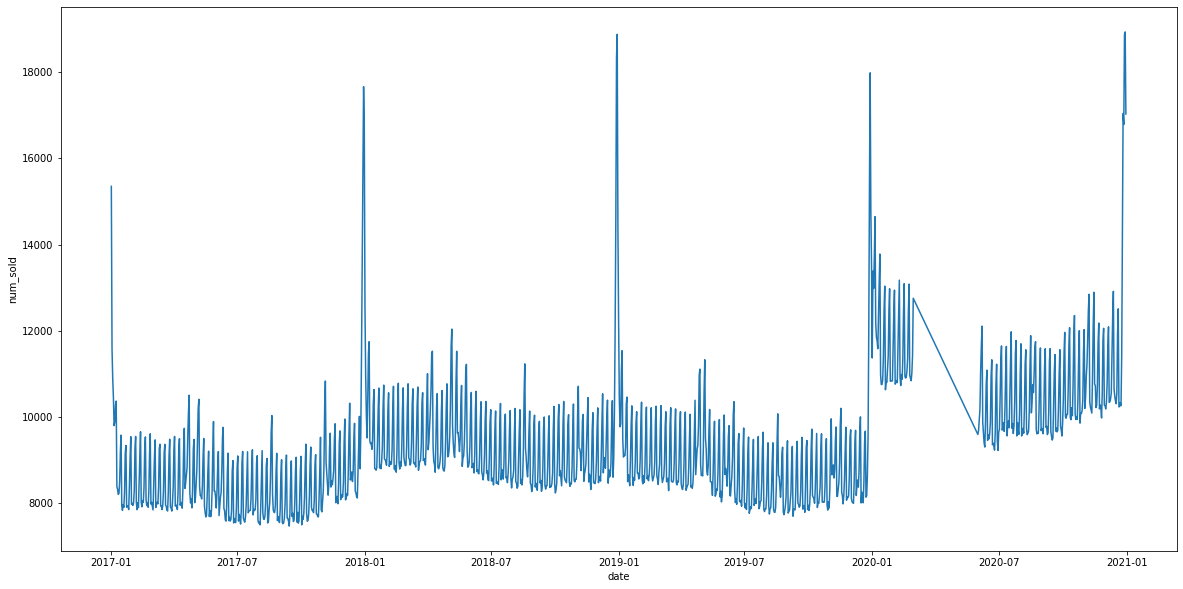

In [32]:
train_nocovid_df = train.loc[~((train["date"] >= "2020-03-01") & (train["date"] < "2020-06-01"))]
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_nocovid_df, x="date", y="num_sold")

In [33]:
train = train_nocovid_df

test_all = test.groupby(["date"])["row_id"].first().reset_index().drop(columns="row_id")

test_all_dates = test_all[["date"]]

## Feature Engineering

In [34]:
def feature_engineer(df):
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear
    #account for leap year
    new_df["day_of_year"] = new_df.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
    new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,362,363,364,365] else 0)
    
    
    new_df["year"] = df["date"].dt.year
    new_df = new_df.drop(columns=["date","month","day_of_year"])
    
    new_df = pd.get_dummies(new_df, columns = ["important_dates","day_of_week"], drop_first=True)
    
    return new_df

In [35]:
train_all = feature_engineer(train)
test_all = feature_engineer(test_all)

In [36]:
display(train_all.head(2))
display(test_all.head(2))

num_sold  month_sin  month_cos  year  important_dates_1  important_dates_2  \
0     15352        0.5   0.866025  2017                  1                  0   
1     11578        0.5   0.866025  2017                  0                  1   

   important_dates_3  important_dates_4  important_dates_5  important_dates_6  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   

   ...  important_dates_126  important_dates_360  important_dates_361  \
0  ...                    0                    0                    0   
1  ...                    0                    0                    0   

   important_dates_362  important_dates_363  important_dates_364  \
0                    0                    0                    0   
1                    0                    0                    0   

   important_dates_365  day_of_week_1  day_of_week_2  day_of_week_3  
0                    0              0              0              1  
1                    0              0              0              0  

[2 rows x 23 columns]

month_sin  month_cos  year  important_dates_1  important_dates_2  \
0        0.5   0.866025  2021                  1                  0   
1        0.5   0.866025  2021                  0                  1   

   important_dates_3  important_dates_4  important_dates_5  important_dates_6  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   

   important_dates_7  ...  important_dates_126  important_dates_360  \
0                  0  ...                    0                    0   
1                  0  ...                    0                    0   

   important_dates_361  important_dates_362  important_dates_363  \
0                    0                    0                    0   
1                    0                    0                    0   

   important_dates_364  important_dates_365  day_of_week_1  day_of_week_2  \
0                    0                    0              1              0   
1                    0                    0              0              1   

   day_of_week_3  
0              0  
1              0  

[2 rows x 22 columns]

In [37]:
y = train_all["num_sold"]
X = train_all.drop(columns="num_sold")
X_Test = test_all

In [38]:
model = Ridge(tol=1e-2, max_iter=1000000, random_state=0)
model.fit(X, y)
preds = model.predict(X_Test)
test_all_dates["num_sold"] = preds

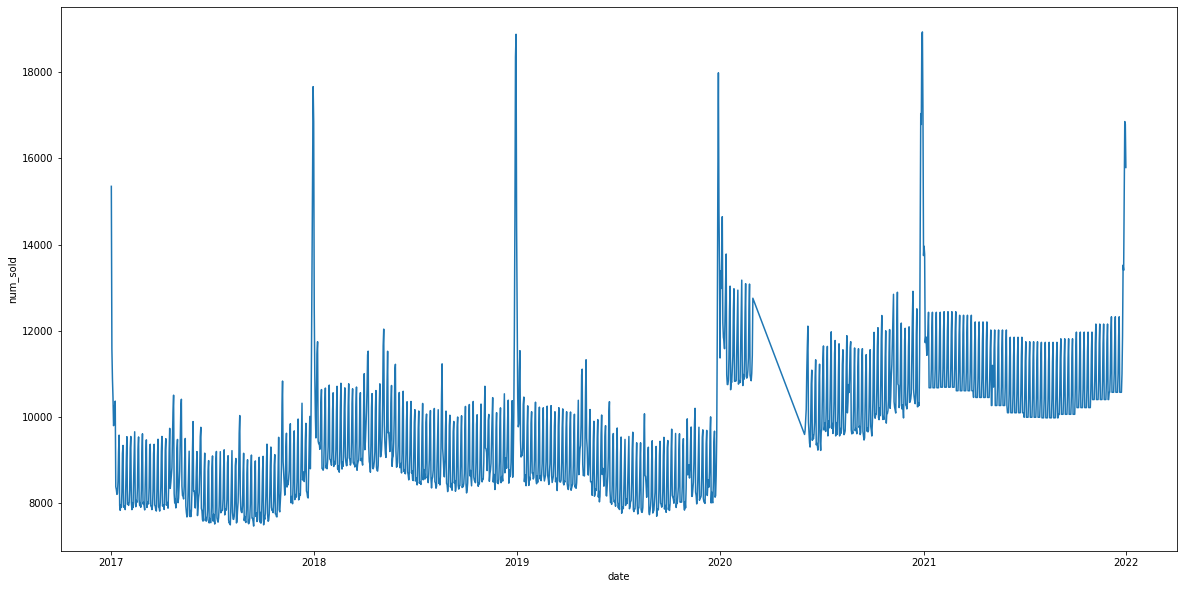

In [39]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = pd.concat([train,test_all_dates]).reset_index(drop=True), x="date", y="num_sold");

## Product Ratio Forecast

In [40]:
product_ratio_2019 = product_ratio_df.loc[product_ratio_df["date"].dt.year == 2019].copy()
product_ratio_2019["mm-dd"] = product_ratio_2019["date"].dt.strftime('%m-%d')
product_ratio_2019 = product_ratio_2019.drop(columns="date")

test_product_ratio_df = test.copy()
test_product_ratio_df["mm-dd"] = test_product_ratio_df["date"].dt.strftime('%m-%d')

test_product_ratio_df = pd.merge(test_product_ratio_df,product_ratio_2019, how="left", on = ["mm-dd","product"])
test_product_ratio_df.head()

row_id       date  country       store                           product  \
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   mm-dd    ratios  
0  01-01  0.279273  
1  01-01  0.230832  
2  01-01  0.188119  
3  01-01  0.301776  
4  01-01  0.279273

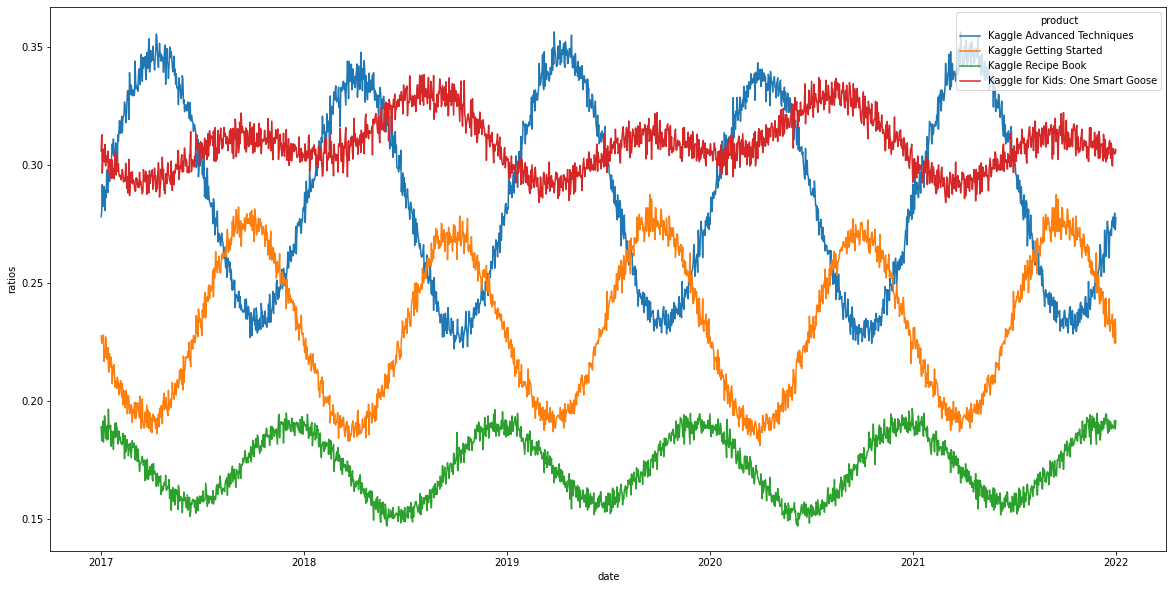

In [41]:
temp_df = pd.concat([product_ratio_df,test_product_ratio_df]).reset_index(drop=True)
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=temp_df, x="date", y="ratios", hue="product");

# Part 6: Disaggregating Total Sales Forecast

In [42]:
test_sub_df = pd.merge(test, test_all_dates, how="left")
test_sub_df["ratios"] = test_product_ratio_df["ratios"]
def disaggregate_forecast(df):
    new_df = df.copy()
    
    stores_weights = original_train.groupby("store")["num_sold"].sum()/original_train["num_sold"].sum()
    country_weights = pd.Series(index = test_sub_df["country"].unique(),data = 1/6)

    for country in country_weights.index:
        new_df.loc[(new_df["country"] == country), "num_sold"] = new_df.loc[(new_df["country"] == country), "num_sold"] *  country_weights[country]
        
    for store in store_weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * store_weights[store]
    
    #apply product weights (which is dependent on date)
    new_df["num_sold"] = new_df["num_sold"] * new_df["ratios"]
    new_df["num_sold"] = new_df["num_sold"].round()
    new_df = new_df.drop(columns=["ratios"])
    
    return new_df

final_df = disaggregate_forecast(test_sub_df)
final_df

row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product  num_sold  
0            Kaggle Advanced Techniques     475.0  
1                Kaggle Getting Started     393.0  
2                    Kaggle Recipe Book     320.0  
3      Kaggle for Kids: One Smart Goose     513.0  
4            Kaggle Advanced Techniques     165.0  
...                                 ...       ...  
17515  Kaggle for Kids: One Smart Goose     599.0  
17516        Kaggle Advanced Techniques     188.0  
17517            Kaggle Getting Started     152.0  
17518                Kaggle Recipe Book     130.0  
17519  Kaggle for Kids: One Smart Goose     208.0  

[17520 rows x 6 columns]

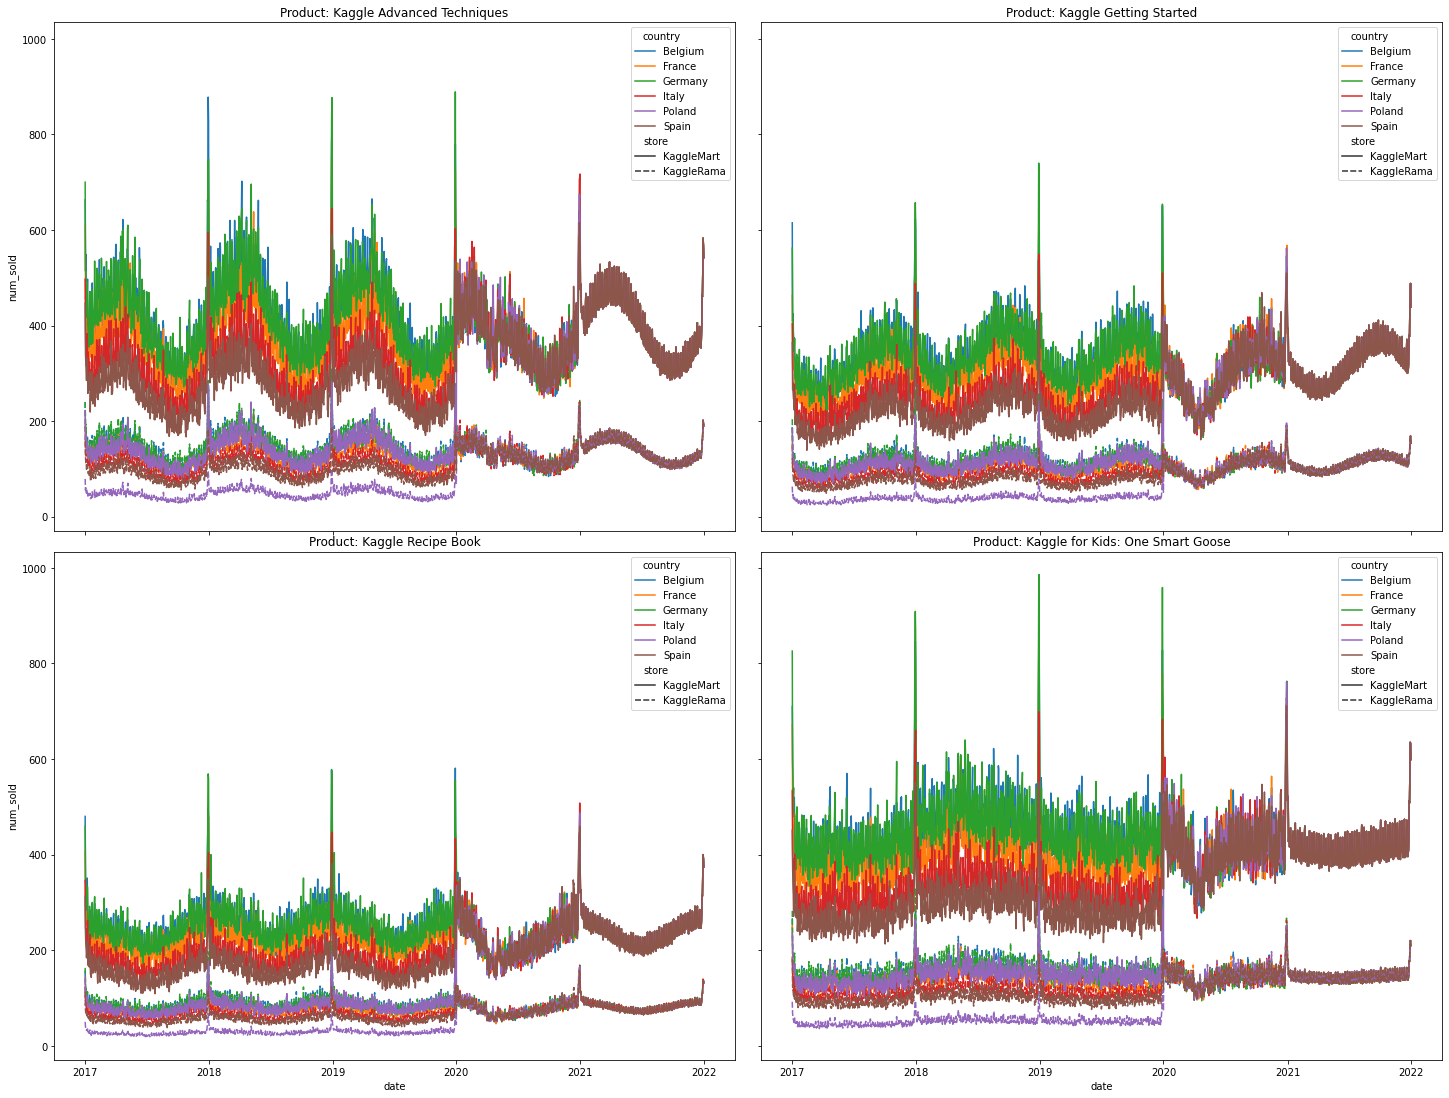

In [43]:
plot_all(pd.concat([original_train,final_df]).reset_index(drop=True))